## Reference Link:
 - [**Python gym.envs.classic_control**](https://www.programcreek.com/python/index/8261/gym.envs.classic_control)
 

#### You will model in Gym a problem domain involving a robotic manipulator (a "robotic arm") engaged in a pick-and-place task.     We will consider the setting where a manipulator with two revolute joints and a two-fingered gripper is tasked with picking a bolt and inserting it into a hole in a metal sheet. An illustration of the setup is shown below.

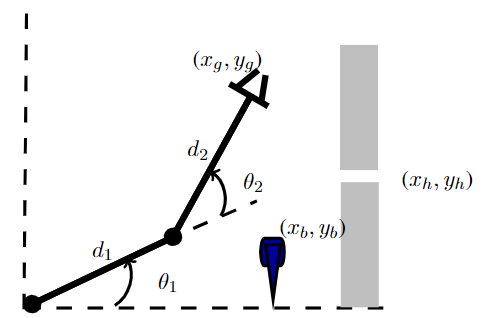

In [1]:
from IPython.display import Image
Image('fig/Assignment_1.png', width=500)

### We will model the manipulator's 2D workspace using the joint angles and whether the gripper is closed or open. Note how the angles are measured. The relation between the gripper's position at (x_g, y_g) and the corresponding joint angles can be written using simple trigonometry as: 

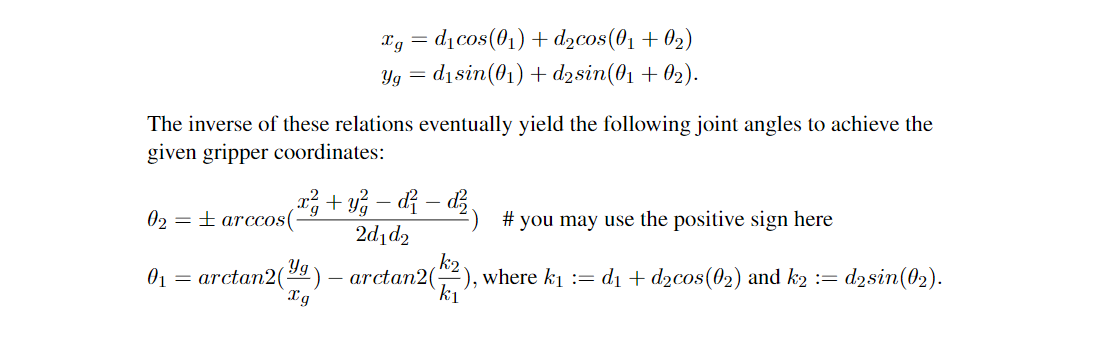

**From above computation, the location of bolt (2.176, 0.643) should correspond to (40, -60); the location of hole (2.266, 0.643) should correspond to (40, -40).** 

(xb, yb) = (2.176, .129);  (xh, yh) = (2.266, .643)                 
(theta1, theta2) = (40, -60);  (theta1, theta2) = (40, -40)                         
                             

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import time

## State/Observation Space: 
There are 5 factor we will consider in state definition, **[theta1, theta2, with/without bolt, gripper open/close]**. 

## Action Space: 
Range for theta1: [0, 20, 40, 60]; range for theta2: [-60, -40, -20, 0, 20, 40, 60].         
Action for theta1, theta2: [-20, 0, 20];   
Action for gripper: [Open/0, Close/1];                    
   
There are 18 (3* 3* 2) discrete action the agent can choose.      

Action|theta1|theta2|Grip
----|----|----|----
0 |-20| -20| 0 
1 |-20| +0| 0 
2 |-20| +20| 0 
3 | +0| -20| 0 
4 | +0|  +0| 0
5 | +0| +20| 0 
6 |+20| -20| 0 
7 |+20|  +0| 0 
8 |+20| +20| 0 
9 |-20| -20| 1 
10 |-20| +0| 1 
11|-20| +20| 1 
12| +0| -20| 1
13| +0|  +0| 1
14| +0| +20| 1 
15|+20| -20| 1 
16|+20|  +0| 1 
17|+20| +20| 1



Action|theta1|theta2|Grip
----|----|----|----
0 |-20| -20| 0 
1 |-20| +20| 0 
2 |+20| -20| 0 
3 |+20| +20| 0 
4 |-20| -20| 1
5 |-20| +20| 1 
6 |+20| -20| 1 
7 |+20| +20| 1 


In [3]:
class RoboticArm(Env):  
    def __init__(self):
        
        self.d1 = 1
        self.d2 = 1.5
        self.xb = 2.176
        self.yb = .129
        self.xh = 2.266
        self.yh = .643
        self.theta1_bolt = 40
        self.theta2_bolt = -60
        self.theta1_hole = 40
        self.theta2_hole = -40 
        
        self.viewer = None
        # Actions we can take, down, stay, up
        self.action_space = Discrete(18)
        # Temperature array
        self.observation_space = Box(low=np.array([0,-60,0,0]), high=np.array([60,60,1,1]))
        # Set start temp
        self.state = np.array([40,0,0,0], dtype=np.float32)
    
    def step(self, action):
        s = self.state
        # Apply action
        if action <= 8: 
            grip = 0
        else:
            grip = 1
            action = action - 9
        
        if int(action/3) == 0:
            theta1 = -20
        elif int(action/3) == 1:
            theta1 = 0
        else:
            theta1 = 20
            
        if action%3 == 0:
            theta2 = -20
        elif action%3 == 1:
            theta2 = 0 
        else: 
            theta2 = 20
        
        self.state[0] = self.state[0] + theta1
        self.state[1] = self.state[1] + theta2 
        
        if s[0] < 0:
            s[0] = 0
            theta1 = 0
        if s[0] > 60:
            s[0] = 60
            theta1 = 0
        if s[1] < -60:
            s[1] = -60
            theta2 = 0
        if s[1] > 60:
            s[1] = 60
            theta2 = 0
        
        xg = np.round((self.d1 * np.cos(s[0]*np.pi/180) + self.d2 * np.cos((s[0]+s[1])*np.pi/180)),3)
        yg = np.round((self.d1 * np.sin(s[0]*np.pi/180) + self.d2 * np.sin((s[0]+s[1])*np.pi/180)),3)
        
        done = False
        
        if xg >= self.xh and yg != self.yh:
            reward = -100
        elif s[0] == self.theta1_hole and s[1] == self.theta2_hole and s[2] == 1 and grip == 0:
            reward = +10
            done = True
        else: 
            reward = -1

        if grip == 0: 
            s[2] = 0
        
        if s[0] == self.theta1_bolt and s[1] == self.theta2_bolt and grip == 1:
            s[2] = 1 
        
        s[3] = grip
        
        #print("state:",self.state,"reward:",reward)
        
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info
    
    
    def render(self, mode="human"):
        from gym.envs.classic_control import rendering

        s = self.state

        print("state:",s)
        if self.viewer is None:
            self.viewer = rendering.Viewer(500, 500)
            bound = self.d1 + self.d2 + 0.2  # 2.2 for default
            self.viewer.set_bounds(-1.5, 1.5*bound, -1.5, 1.5*bound)

        if s is None:
            return None
        
        xg = np.round((self.d1 * np.cos(s[0]*np.pi/180) + self.d2 * np.cos((s[0]+s[1])*np.pi/180)),3)
        yg = np.round((self.d1 * np.sin(s[0]*np.pi/180) + self.d2 * np.sin((s[0]+s[1])*np.pi/180)),3)
        
        p1 = [np.round((self.d1 * np.cos(s[0]*np.pi/180)),3), np.round((self.d1 * np.sin(s[0]*np.pi/180)),3)]

        p2 = [xg, yg]
      
        self.viewer.draw_line((2.266, 0), (2.266, 0.62))
        self.viewer.draw_line((2.266, 0.68), (2.266, 2))
        self.viewer.draw_line((0, 0), (1, 0))
        self.viewer.draw_line((0, 0), (0, 1))
        
        ### Draw Link and Circle 
        l, r, t, b = 0, 1, 0.05, -0.05
        jtransform = rendering.Transform(rotation= s[0]*np.pi/180, translation=(0, 0))
        link = self.viewer.draw_polygon([(l, b), (l, t), (r, t), (r, b)])
        link.add_attr(jtransform)
        link.set_color(0, 0.8, 0.8)
                
        circ = self.viewer.draw_circle(0.06)
        circ.set_color(0.8, 0.8, 0)
        circ.add_attr(jtransform)
        
        l, r, t, b = 0, 1.5, 0.05, -0.05
        jtransform = rendering.Transform(rotation= (s[0]+s[1])*np.pi/180, translation=(p1[0], p1[1]))
        link = self.viewer.draw_polygon([(l, b), (l, t), (r, t), (r, b)])
        link.add_attr(jtransform)
        link.set_color(0, 0.8, 0.8)
        
        circ = self.viewer.draw_circle(0.06)
        circ.set_color(0.8, 0.8, 0)
        circ.add_attr(jtransform)
        
        if s[2] == 0.0 and done == False:
            ### Bolt in Originial Location
            jtransform = rendering.Transform(rotation= 0, translation=(2.176, 0.13))
            circ = self.viewer.draw_circle(0.10)
            circ.set_color(0.8, 0, 0.8) 
            circ.add_attr(jtransform)

            jtransform = rendering.Transform(rotation= 0, translation=(p2[0], p2[1]))
            circ = self.viewer.draw_circle(0.06)
            circ.set_color(0.8, 0.8, 0)
            circ.add_attr(jtransform)
        if s[2] == 1.0:
            ### Bolt in Gripper
            print("haohaohao")
            jt = rendering.Transform(rotation= 0, translation=(p2[0]+0.1*np.cos((s[0]+s[1])*np.pi/180), p2[1]+0.1*np.sin((s[0]+s[1])*np.pi/180)))
            circ = self.viewer.draw_circle(0.10)
            circ.set_color(0.8, 0, 0.8)
            circ.add_attr(jt)
        if done == True:
            ### Bolt in Hole Location
            jtr = rendering.Transform(rotation= 0, translation=(2.266, 0.643))
            circ = self.viewer.draw_circle(0.10)
            circ.set_color(0.8, 0, 0.8) 
            circ.add_attr(jtr)
        
       ### Draw Gripper
        gripperwidth = 0.3
        gripperheight = 0.05
        angle = (s[0]+s[1])
        l, r, t, b = -gripperwidth / 2, gripperwidth / 2, gripperheight / 2, -gripperheight / 2
        gripper = self.viewer.draw_polygon([(l, b), (l, t), (r, t), (r, b)])
        jtransform = rendering.Transform(rotation= (angle+90)*np.pi/180, translation=(p2[0], p2[1]))
        gripper.add_attr(jtransform)

        if s[3] == 0:
            ### Draw Open Gripper
            gripper = self.viewer.draw_polygon([(l/1.2, b/3), (l/1.2, t/3), (r/1.2, t/3), (r/1.2, b/3)])
            jtransform = rendering.Transform(rotation= angle*np.pi/180, translation=(p2[0]+0.4*gripperwidth*np.sin(angle*np.pi/180)+0.3*gripperwidth*np.cos(angle*np.pi/180), p2[1]-0.4*gripperwidth*np.cos(angle*np.pi/180)+0.3*gripperwidth*np.sin(angle*np.pi/180)))
            gripper.add_attr(jtransform)
            gripper = self.viewer.draw_polygon([(l/1.2, b/3), (l/1.2, t/3), (r/1.2, t/3), (r/1.2, b/3)])
            jtransform = rendering.Transform(rotation= angle*np.pi/180, translation=(p2[0]-0.4*gripperwidth*np.sin(angle*np.pi/180)+0.3*gripperwidth*np.cos(angle*np.pi/180), p2[1]+0.4*gripperwidth*np.cos(angle*np.pi/180)+0.3*gripperwidth*np.sin(angle*np.pi/180)))
            gripper.add_attr(jtransform)
        else:
            ### Draw Close Gripper
            gripper = self.viewer.draw_polygon([(l/1.2, b/3), (l/1.2, t/3), (r/1.2, t/3), (r/1.2, b/3)])
            jtransform = rendering.Transform(rotation= (angle+30)*np.pi/180, translation=(p2[0]+0.3*gripperwidth*np.sin(angle*np.pi/180)+0.3*gripperwidth*np.cos(angle*np.pi/180), p2[1]-0.3*gripperwidth*np.cos(angle*np.pi/180)+0.3*gripperwidth*np.sin(angle*np.pi/180)))
            gripper.add_attr(jtransform)
            gripper = self.viewer.draw_polygon([(l/1.2, b/3), (l/1.2, t/3), (r/1.2, t/3), (r/1.2, b/3)])
            jtransform = rendering.Transform(rotation= (angle-30)*np.pi/180, translation=(p2[0]-0.3*gripperwidth*np.sin(angle*np.pi/180)+0.3*gripperwidth*np.cos(angle*np.pi/180), p2[1]+0.3*gripperwidth*np.cos(angle*np.pi/180)+0.3*gripperwidth*np.sin(angle*np.pi/180)))
            gripper.add_attr(jtransform)
            
        
        return self.viewer.render(return_rgb_array=mode == "rgb_array")
    
    def reset(self):
        self.state = np.array([40,0,0,0], dtype=np.float32)
        #self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        #self.steps_beyond_done = None                #############################
        return self.state
       
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


In [4]:
env = RoboticArm()

C:\Users\gs70055\Anaconda3\envs\rl\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


## Randomly Test

In [6]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        time.sleep(.05)
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    env.render()
    env.close()
    print('Episode:{} Score:{}'.format(episode, score))

state: [40.  0.  0.  0.]
state: [ 60. -20.   0.   0.]
state: [60.  0.  0.  0.]
state: [60. 20.  0.  0.]
state: [60. 40.  0.  1.]
state: [60. 60.  0.  0.]
state: [60. 60.  0.  1.]
state: [40. 60.  0.  0.]
state: [20. 60.  0.  1.]
state: [ 0. 40.  0.  0.]
state: [ 0. 20.  0.  1.]
state: [0. 0. 0. 1.]
state: [ 20. -20.   0.   0.]
state: [ 20. -20.   0.   1.]
state: [40.  0.  0.  0.]
state: [60. 20.  0.  1.]
state: [60. 40.  0.  1.]
state: [60. 20.  0.  1.]
state: [60.  0.  0.  1.]
state: [40.  0.  0.  1.]
state: [40.  0.  0.  1.]
state: [60.  0.  0.  0.]
state: [ 40. -20.   0.   1.]
state: [20.  0.  0.  0.]
state: [ 20. -20.   0.   0.]
state: [20.  0.  0.  0.]
state: [ 20. -20.   0.   0.]
state: [ 40. -40.   0.   0.]
state: [ 40. -20.   0.   0.]
state: [ 20. -20.   0.   1.]
state: [40.  0.  0.  1.]
state: [40. 20.  0.  0.]
state: [40.  0.  0.  1.]
state: [ 60. -20.   0.   0.]
state: [ 60. -40.   0.   0.]
state: [ 60. -60.   0.   1.]
state: [ 40. -60.   0.   0.]
state: [ 20. -60.   0.   1.

state: [ 0. 60.  0.  0.]
state: [ 0. 60.  0.  0.]
state: [20. 60.  0.  1.]
state: [ 0. 60.  0.  1.]
state: [20. 60.  0.  1.]
state: [ 0. 40.  0.  0.]
state: [ 0. 20.  0.  0.]
state: [0. 0. 0. 0.]
state: [  0. -20.   0.   1.]
state: [  0. -40.   0.   0.]
state: [  0. -40.   0.   1.]
state: [  0. -20.   0.   1.]
state: [20.  0.  0.  0.]
state: [20. 20.  0.  0.]
state: [20. 20.  0.  1.]
state: [ 0. 20.  0.  1.]
state: [ 0. 20.  0.  0.]
state: [ 0. 40.  0.  0.]
state: [ 0. 20.  0.  1.]
state: [ 0. 40.  0.  1.]
state: [ 0. 40.  0.  1.]
state: [ 0. 60.  0.  1.]
state: [ 0. 60.  0.  1.]
state: [ 0. 40.  0.  1.]
state: [ 0. 40.  0.  0.]
state: [ 0. 20.  0.  1.]
state: [ 0. 40.  0.  1.]
state: [20. 40.  0.  1.]
state: [20. 60.  0.  0.]
state: [40. 60.  0.  1.]
state: [20. 60.  0.  1.]
state: [ 0. 60.  0.  0.]
state: [ 0. 40.  0.  0.]
state: [20. 20.  0.  0.]
state: [20. 40.  0.  0.]
state: [40. 60.  0.  0.]
state: [60. 40.  0.  1.]
state: [60. 60.  0.  1.]
state: [60. 60.  0.  0.]
state: [60. 6

state: [ 60. -60.   0.   0.]
state: [ 60. -60.   0.   0.]
state: [ 40. -40.   0.   1.]
state: [ 40. -60.   1.   1.]
haohaohao
state: [ 20. -60.   1.   1.]
haohaohao
state: [ 20. -60.   1.   1.]
haohaohao
state: [ 20. -60.   1.   1.]
haohaohao
state: [ 20. -60.   1.   1.]
haohaohao
state: [ 40. -60.   1.   1.]
haohaohao
state: [ 60. -60.   1.   1.]
haohaohao
state: [ 60. -60.   1.   1.]
haohaohao
state: [ 60. -60.   1.   1.]
haohaohao
state: [ 60. -60.   0.   0.]
state: [ 60. -60.   0.   1.]
state: [ 60. -40.   0.   1.]
state: [ 60. -40.   0.   0.]
state: [ 60. -40.   0.   0.]
state: [ 60. -20.   0.   1.]
state: [40.  0.  0.  0.]
state: [ 60. -20.   0.   0.]
state: [ 40. -20.   0.   0.]
state: [ 20. -40.   0.   0.]
state: [  0. -40.   0.   0.]
state: [ 20. -60.   0.   1.]
state: [ 40. -60.   0.   0.]
state: [ 60. -60.   0.   0.]
state: [ 60. -60.   0.   0.]
state: [ 60. -40.   0.   0.]
state: [ 60. -40.   0.   1.]
state: [ 60. -20.   0.   1.]
state: [40.  0.  0.  0.]
state: [60. 20.  0.

## Create a Deep Learning Model with Keras

In [6]:
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
states = env.observation_space.shape
actions = env.action_space.n

In [8]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [9]:
model = build_model(states, actions)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                450       
Total params: 1,170
Trainable params: 1,170
Non-trainable params: 0
_________________________________________________________________


## Build Agent with Keras-RL

In [10]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [11]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [12]:
#dqn = build_agent(model, actions)
#dqn.compile(Adam(lr=1e-3), metrics=['mae'])
#dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)